# Demo 6: building and validating a Dragonian dual reflector

In this demo, we build a [Dragonian reflector](https://ieeexplore.ieee.org/document/979502) and validate its design by simulating the propagation of a Gaussian beam through the setup. Specifically, we propagate from one focus of the Dragonian to the other. We compare the beamwidths of the Gaussian at both focii and see if they match.

The Dragonian in this demo is an existing model, currently used for aligning the DESHIMA 2.0 spectrometer. It has a magnification factor of 1.89, and it is this factor that we will check now.

WARNING: this demo is quite heavy on the hardware. If you do not have a CUDA capable graphics card, this demo can take a long time to finish. If you do have a CUDA graphics card, this demo should be no problem to run.

2026-02-23 14:06:13 - WARNING - System override set to True. 
2026-02-23 14:06:13 - INFO - Added hyperboloid h_wo to system. 
2026-02-23 14:06:13 - INFO - Added ellipsoid e_wo to system. 
2026-02-23 14:06:13 - INFO - Rotated element h_wo by ('1.800e+02', '0.000e+00', '0.000e+00') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2026-02-23 14:06:13 - INFO - Translated element h_wo by ('0.000e+00', '0.000e+00', '1.268e+03') millimeters. 
2026-02-23 14:06:13 - INFO - Rotated element h_wo by ('0.000e+00', '6.500e+01', '0.000e+00') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2026-02-23 14:06:13 - INFO - Rotated element e_wo by ('1.800e+02', '9.000e+01', '0.000e+00') degrees around ('0.000e+00', '0.000e+00', '0.000e+00'). 
2026-02-23 14:06:13 - INFO - Translated element e_wo by ('1.392e+03', '0.000e+00', '1.222e+03') millimeters. 
2026-02-23 14:06:13 - INFO - Rotated element e_wo by ('0.000e+00', '9.390e+00', '0.000e+00') degrees around ('1.392e+03', '0.000e+00', '1.222e

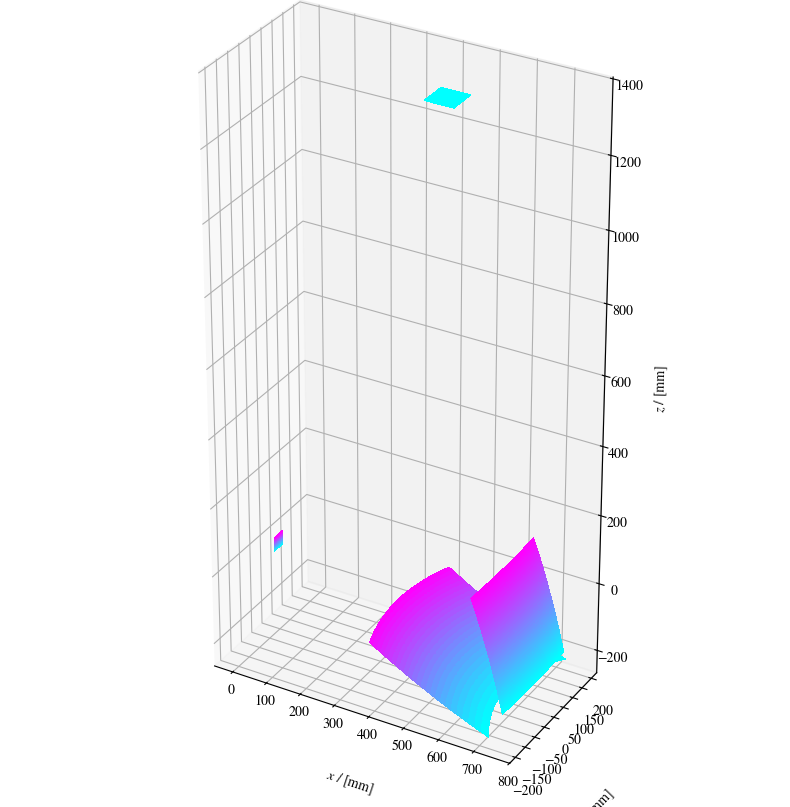

In [ ]:
#%matplotlib widget
# Uncomment for interactive plots when running the notebook!
# Requires installation of the ipympl package

import numpy as np

from PyPO.System import System
from PyPO.Enums import FieldComponents, Projections, Units

# Ellipsoidal reflector: note that these parameters are for the 2D case.
_A_ELLIPSE  = 3689.3421*Units.MM / 2             # Semi-major axis in mm
_C_ELLIPSE  = 1836.4965*Units.MM / 2             # Focii distance in mm
_B_ELLIPSE  = 3199.769638*Units.MM / 2           # Semi-minor axis in mm

_X_LIM_ELL  = np.array([1435, 1545])*Units.MM    # In frame where lower ellipse vertex is at origin
_Y_LIM_ELL  = np.array([-200, 200])*Units.MM

# Hyperboloid reflector: note that these parameters are for the 2D case.
_A_HYPERBO  = 1226.5776*Units.MM / 2             # Vertex distance in mm
_C_HYPERBO  = 2535.878*Units.MM / 2              # Focii distance in mm
_B_HYPERBO  = 2219.500985*Units.MM / 2           # Semi-minor axis in mm

_X_LIM_HYP  = np.array([160, 480])*Units.MM
_Y_LIM_HYP  = np.array([-160, 160])*Units.MM

# First, define focii of hyperbola and ellipsoid
h_f0 = np.zeros(3) # Horizontal focus of Dragonian = lower focus of hyperboloid
h_f1 = np.array([2298.285978374926, 0.0, 1071.7083523464814])*Units.MM # Upper hyperboloid focus - 
                                                              # co-incides with far ellipsoid focus

e_f0 = np.array([486.3974883317985, 0.0, 1371.340617233771])*Units.MM # Upper focus of Dragonian = close ellipsoid focus
e_f1 = h_f1 # Far ellipsoid focus

e_center = (e_f1 + e_f0) / 2 
diff = (e_f1 - e_f0) / np.sqrt(np.dot(e_f1 - e_f0, e_f1 - e_f0))
theta = np.degrees(np.arccos(np.dot(np.array([1,0,0]), diff)))
#print(theta)

# Initialize system
s = System()

# Add parabolic reflector and hyperbolic reflector by focus, vertex and two foci and eccentricity
h_coeff = np.array([_B_HYPERBO, _B_HYPERBO, _A_HYPERBO])
h_gridsize = np.array([201, 201])

e_coeff = np.array([_B_ELLIPSE, _B_ELLIPSE, _A_ELLIPSE])
e_gridsize = np.array([101, 101])

h_wo = {
        "name"      : "h_wo",
        "pmode"     : "manual",
        "gmode"     : "xy",
        "coeffs"    : h_coeff,
        "flip"      : False,
        "lims_x"    : _X_LIM_HYP,
        "lims_y"    : _Y_LIM_HYP,
        "gridsize"  : h_gridsize
        }

e_wo = {
        "name"      : "e_wo",
        "pmode"     : "manual",
        "gmode"     : "xy",
        "coeffs"    : e_coeff,
        "flip"      : True,
        "lims_x"    : _X_LIM_ELL,
        "lims_y"    : _Y_LIM_ELL,
        "gridsize"  : e_gridsize
        }

s.addHyperbola(h_wo)
s.addEllipse(e_wo)

s.rotateGrids("h_wo", np.array([180, 0, 0]), pivot=np.zeros(3))
s.translateGrids("h_wo", np.array([0, 0, _C_HYPERBO]))
s.rotateGrids("h_wo", np.array([0, 65, 0]), pivot=np.zeros(3))

s.rotateGrids("e_wo", np.array([180, 90, 0]), pivot=np.zeros(3))
s.translateGrids("e_wo", e_center)
s.rotateGrids("e_wo", np.array([0, 1*theta, 0]), pivot=e_center)

# Build the plane in the horizontal focus for the source Gaussian beam.
focus1 = {
        "name"     : "focus1",
        "gmode"    : "xy",
        "lims_x"   : np.array([-20, 20])*Units.MM,
        "lims_y"   : np.array([-20, 20])*Units.MM,
        "gridsize" : np.array([101, 101])
        }

s.addPlane(focus1)

# Define Gaussian on focus1 before rotating
GPOfield =  {
        "name"      : "Gauss1",
        "lam"       : 1*Units.MM,
        "w0x"       : 10*Units.MM,
        "w0y"       : 10*Units.MM,
        "n"         : 1,
        "E0"        : 1, 
        "dxyz"      : 0,
        "pol"       : np.array([1,0,0])
}

s.createGaussian(GPOfield, "focus1")

# Rotate the plane with 90 degrees around the y axis so that it faces the hyperboloid mirror.
s.rotateGrids("focus1", np.array([0, 90, 0]))

s.autoConverge("Gauss1", "h_wo")

# Build the plane in the vertical focus for calculation.
focus2 = {
        "name"     : "focus2",
        "gmode"    : "xy",
        "lims_x"   : np.array([-40, 40])*Units.MM,
        "lims_y"   : np.array([-40, 40])*Units.MM,
        "gridsize" : np.array([101, 101])
        }

s.addPlane(focus2)
s.translateGrids("focus2", e_f0)

s.plotSystem()

We plot the Dragonian reflector. We also plot the planes we defined in the two focii. Now we will start the calculations. WARNING! If not using CUDA, this can take a long time!

In [ ]:
runPODict1 = {
            "t_name"    : "h_wo",
            "s_current" : "Gauss1",
            "exp"       : "fwd",
            "mode"      : "JMEH",
            "name_JM"   : "JM_h",
            "name_EH"   : "EH_h",
            }

s.runPO(runPODict1)

s.autoConverge("EH_h", "e_wo")

runPODict2 = {
            "t_name"    : "e_wo",
            "s_current" : "JM_h",
            "exp"       : "fwd",
            "mode"      : "JMEH",
            "name_JM"   : "JM_e",
            "name_EH"   : "EH_e",
            }

s.runPO(runPODict2)

runPODict3 = {
            "t_name"    : "focus2",
            "s_current" : "JM_e",
            "exp"       : "fwd",
            "mode"      : "EH",
            "name_EH"   : "EH_f2",
            }

s.runPO(runPODict3)

2026-02-23 14:06:15 - WORK - *** Starting PO propagation *** 
2026-02-23 14:06:15 - WORK - Propagating Gauss1 on focus1 to h_wo, propagation mode: JMEH. 
2026-02-23 14:06:15 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-23 14:06:15 - WORK - ... Calculating ... 
2026-02-23 14:06:16 - WORK - *** Finished: 0.407 seconds *** 
2026-02-23 14:06:16 - WORK - *** Starting auto-convergence ***  
2026-02-23 14:06:16 - WORK - Difference : 1e+99 at gridsize ('1.100e+01', '1.100e+01') 
2026-02-23 14:06:16 - WORK - Difference : 0.04200939638509826 at gridsize ('2.100e+01', '2.100e+01') 
2026-02-23 14:06:16 - WORK - Difference : 0.0136284467289286 at gridsize ('3.100e+01', '3.100e+01') 
2026-02-23 14:06:17 - WORK - Difference : 0.006722749651820514 at gridsize ('4.100e+01', '4.100e+01') 
2026-02-23 14:06:17 - RESULT - Found converged solution, gridsize: ('3.690e+02', '3.690e+02') 
2026-02-23 14:06:17 - WORK - *** Starting PO propagation *** 
2026-02-23 14:06:17 - WORK - Propagating J

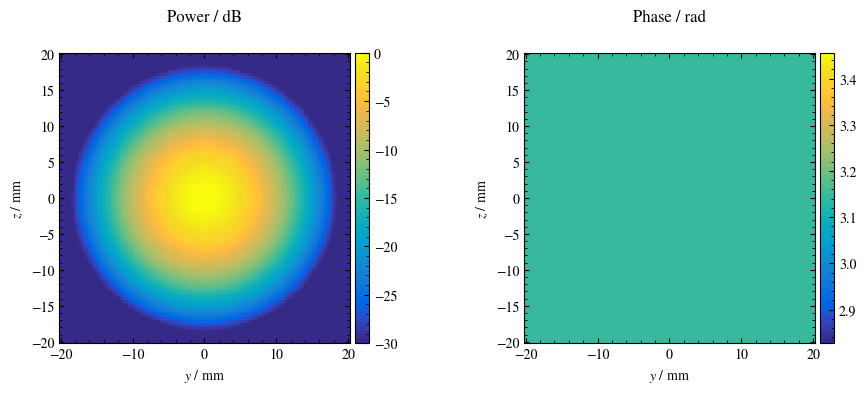

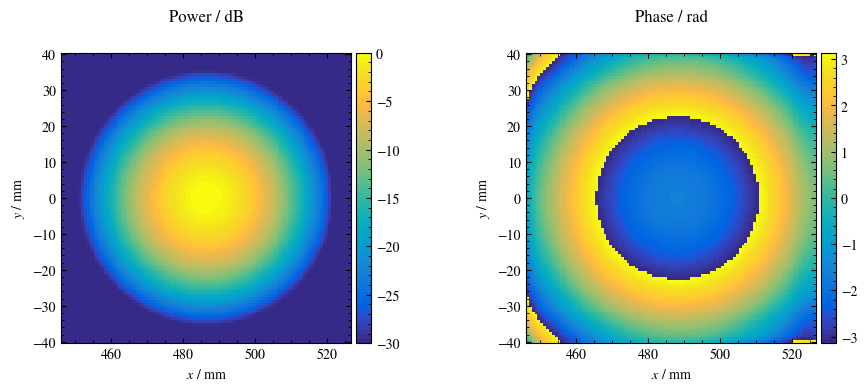

Focus 1: E-HPBW = 11.76, H-HPBW = 11.72 degrees
Focus 2: E-HPBW = 22.40, H-HPBW = 22.40 degrees
Mean PO magnification: M = 1.91
Fractional error: dM/M = 0.01


In [ ]:
s.plotBeam2D("Gauss1", FieldComponents.Ez, project=Projections.yz, vmin=-30)
s.plotBeam2D("EH_f2", FieldComponents.Ex, project=Projections.xy, vmin=-30)

E1, H1 = s.calcHPBW("Gauss1", FieldComponents.Ex)
E2, H2 = s.calcHPBW("EH_f2", FieldComponents.Ex)

mean_mag = (E2/E1 + H2/H1) / 2

print(f"Focus 1: E-HPBW = {E1:.2f}, H-HPBW = {H1:.2f} degrees")
print(f"Focus 2: E-HPBW = {E2:.2f}, H-HPBW = {H2:.2f} degrees")
print(f"Mean PO magnification: M = {mean_mag:.2f}")
print(f"Fractional error: dM/M = {(mean_mag - 1.89)/1.89:.2f}")

The top plot shows the Gaussian beam in focus 1, i.e. the starting beam pattern. Below, we find the beam pattern in focus 2, i.e. the termination point of the simulation. It can be seen, qualitatively, that both beam patterns look similar.

Quantitatively, the HPBWs indicate that the Dragonian magnifies by a factor of 1.91. This is not the same as the design, but relatively close. In fact, the fractional error, simulated minus design magnification over design, is about 1%.